In [1]:
import dask
import os 

src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(src_path)

import gc
import tracemalloc
import numpy as np
from matplotlib.colors import Normalize
from src.seacast_tools.np_loaders import TargetsFromNumpy, PredictionsFromNumpy
from weatherbenchX.metrics import probabilistic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation
from src.seacast_tools.ensemble_loaders import EnsembleFromNpLoaders
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
def flatten_to_2d(datos, mask, shape=(300, 300)):
    mask = mask.flatten()
    temperature_map = np.zeros_like(mask, dtype=float)

    j = 0
    for i in range(len(mask)):
        if mask[i] == 1:
            temperature_map[i] = datos[j]
            j += 1

    return temperature_map.reshape(shape)

def plot_temperature_map(temperature_map, cmap="inferno"):
    plt.figure(figsize=(6, 6))

    norm = Normalize(vmin=np.min(temperature_map[temperature_map != 0]),
                        vmax=np.max(temperature_map))
    plt.imshow(temperature_map, cmap=cmap, origin='lower', norm=norm)

    plt.colorbar(label="Temperatura")
    plt.title("Mapa de Temperatura")
    plt.show()

tracemalloc.start()
mask = np.load("data/atlantic/static/sea_mask.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'data/atlantic/static/sea_mask.npy'

### Diccionario métricas

In [2]:
dict_metric_names = {
    "crps.sst_temperature": "CRPS",
    "rmse_unb.sst_temperature": "RMSE (sin sesgo)",
    "spread_skill_ratio.sst_temperature": "Spread/skill",
    "spread_skill_ratio_unb.sst_temperature": "Spread/skill (sin sesgo)",
    "rmse.sst_temperature": "RMSE",
    "mae.sst_temperature": "MAE",
    "bias.sst_temperature": "Sesgo",
}

### Función procesamiento de métricas por rango de fechas

In [4]:
metrics = {
    "crps" : probabilistic.CRPSEnsemble(),
    "rmse_unb": probabilistic.UnbiasedEnsembleMeanRMSE(skipna_ensemble=True),
    "spread_skill_ratio": probabilistic.SpreadSkillRatio(skipna_ensemble=True),
    "spread_skill_ratio_unb": probabilistic.UnbiasedSpreadSkillRatio(skipna_ensemble=True),
}

aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude'], skipna=True
)

In [5]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [6]:
def process_and_save_metrics(date_ranges, year, noise_type, directories):
    all_metrics = []
    all_statistics = []
    
    for date_range in date_ranges:
        print(f"Procesando rango de fechas: {date_range[0]} a {date_range[1]}")
        loaders = []
        for directory in directories:
            predictions = PredictionsFromNumpy(
                path=directory,
                variables=variables,
                extra_variables=extra_variables,
                extra_files=extra_files,
                dates=date_range
            )
            loaders.append(predictions)

        ensemble = EnsembleFromNpLoaders(loaders=loaders)
        predictions_dataset = ensemble.build_ensemble()

        directory = r"data\atlantic\samples\test"
        
        targets = TargetsFromNumpy(
            path=directory,
            variables=variables,
            extra_variables=extra_variables,
            extra_files=extra_files,
            dates=date_range
        )
        targets_dataset = targets.load_chunk()


        
        statistics = metrics_base.compute_unique_statistics_for_all_metrics(
            metrics, predictions_dataset, targets_dataset
        )

        aggregation_state = aggregator.aggregate_statistics(statistics)
        dataset_metrics = aggregation_state.metric_values(metrics)
        dataset_metrics["lead_time"] = dataset_metrics["lead_time"].astype("timedelta64[D]")

        all_metrics.append(dataset_metrics)
        all_statistics.append(statistics)

        del predictions_dataset, targets_dataset, statistics, aggregation_state, dataset_metrics, ensemble
        gc.collect()

    combined_metrics = xr.concat(all_metrics, dim="init_time")
    combined_metrics.astype(np.float32).to_netcdf(f"data/atlantic/predictions/ensemble_{noise_type}_{year}.nc")

### Función carga de ensembles

In [7]:
def get_ensemble(directories, date_ranges):
    all_datasets = []
    for date_range in date_ranges:
        print(f"Procesando rango de fechas: {date_range[0]} a {date_range[1]}")
        
        loaders = []
        for directory in directories:
            predictions = PredictionsFromNumpy(
                path=directory,
                variables=variables,
                extra_variables=extra_variables,
                extra_files=extra_files,
                dates=date_range
            )
            loaders.append(predictions)

        ensemble = EnsembleFromNpLoaders(loaders=loaders)
        predictions_dataset = ensemble.build_ensemble()
        all_datasets.append(predictions_dataset)
        
    all_datasets_combined = xr.concat(all_datasets, dim="init_time")
    return all_datasets_combined.astype(np.float32)

### Carga de ensembles para gráficas

#### Gaussiano (std=0.1)

In [8]:
date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

directories_gaussian = [r"data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions", r"data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions", r"data\atlantic\predictions\gaussian\run-20250525_202636-9ucmeenc\files\predictions", r"data\atlantic\predictions\gaussian\run-20250526_001455-nfmwznoc\files\predictions",
r"data\atlantic\predictions\gaussian\run-20250527_190605-gh4g5mks\files\predictions"] 

In [ ]:
ensemble_dataset_gaussian_2022 = get_ensemble(directories_gaussian, date_ranges_2022)
ensemble_dataset_gaussian_2022.to_netcdf("data/atlantic/predictions/ensemble_gaussian_2022_data.nc")

In [6]:
ensemble_dataset_gaussian_2023 = get_ensemble(directories_gaussian, date_ranges_2023)
ensemble_dataset_gaussian_2023.to_netcdf("data/atlantic/predictions/ensemble_gaussian_2023_data.nc")

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_202636-9ucmeenc\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250526_001455-nfmwznoc\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250527_190605-gh4g5mks\files\predictions
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250525_202636-9ucmeen

#### Perlin 3d 2x3x3

In [7]:
directories_perlin_3_3 = [r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions",
r"data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions"] 

In [6]:
ensemble_perlin_3_3_2022 = get_ensemble(directories_perlin_3_3, date_ranges_2022)
ensemble_perlin_3_3_2022.to_netcdf("data/atlantic/predictions/ensemble_perlin_3_3_2022_data.nc")


KeyboardInterrupt



In [8]:
ensemble_perlin_3_3_2023 = get_ensemble(directories_perlin_3_3, date_ranges_2023)
ensemble_perlin_3_3_2023.to_netcdf("data/atlantic/predictions/ensemble_perlin_3_3_2023_data.nc")

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 89 data entries from data\atlantic\predictions\p

#### Perlin 3d 2x12x12

In [7]:
directories_perlin_12_12 = [r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions",
r"data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions"] 

In [7]:
ensemble_perlin_12_12_2022 = get_ensemble(directories_perlin_12_12, date_ranges_2022)
ensemble_perlin_12_12_2022.to_netcdf("data/atlantic/predictions/ensemble_perlin_12_12_2022_data.nc")

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 89 data entries from data\atlantic

In [7]:
ensemble_perlin_12_12_2023 = get_ensemble(directories_perlin_12_12, date_ranges_2023)
ensemble_perlin_12_12_2023.to_netcdf("data/atlantic/predictions/ensemble_perlin_12_12_2023_data.nc")

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 89 data entries from data\atlantic

#### Perlin fractal 1x3x3

In [8]:
directories_perlin_fractal = [r"data\atlantic\predictions\perlin_fractal\run-20250529_123504-gsn31pxv\files\predictions", r"data\atlantic\predictions\perlin_fractal\run-20250530_124508-jf420kyt\files\predictions", r"data\atlantic\predictions\perlin_fractal\run-20250531_172801-ye9kajqq\files\predictions", r"data\atlantic\predictions\perlin_fractal\run-20250601_140952-l2uuvw2x\files\predictions",
r"data\atlantic\predictions\perlin_fractal\run-20250601_162733-yi5t7ib3\files\predictions"] 

In [7]:
ensemble_perlin_fractal_2022 = get_ensemble(directories_perlin_fractal, date_ranges_2022)
ensemble_perlin_fractal_2022.to_netcdf("data/atlantic/predictions/ensemble_perlin_fractal_2022_data.nc")

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250529_123504-gsn31pxv\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250530_124508-jf420kyt\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250531_172801-ye9kajqq\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250601_140952-l2uuvw2x\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250601_162733-yi5t7ib3\files\predictions
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal\run-20250529_123504-gsn31pxv\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal\run-20250530_124508-jf420kyt\files\predictions
Loaded 89 data entries from data\atlantic\predic

In [9]:
ensemble_perlin_fractal_2023 = get_ensemble(directories_perlin_fractal, date_ranges_2023)
ensemble_perlin_fractal_2023.to_netcdf("data/atlantic/predictions/ensemble_perlin_fractal_2023_data.nc")

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250529_123504-gsn31pxv\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250530_124508-jf420kyt\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250531_172801-ye9kajqq\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250601_140952-l2uuvw2x\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal\run-20250601_162733-yi5t7ib3\files\predictions
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal\run-20250529_123504-gsn31pxv\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal\run-20250530_124508-jf420kyt\files\predictions
Loaded 89 data entries from data\atlantic\predic

#### Viendo diferencias de ensemble para 2022

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15396\2783706261.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  "Gaussiano ($\\mu$=0, $\\sigma$=0.1)": xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2022_data.nc"),
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15396\2783706261.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  "P_res_2x3x3": xr.open_dataset("data/atlantic/predictions/ensemble_perlin_3_3_2022_data.nc"),
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15396\2783706261.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimed

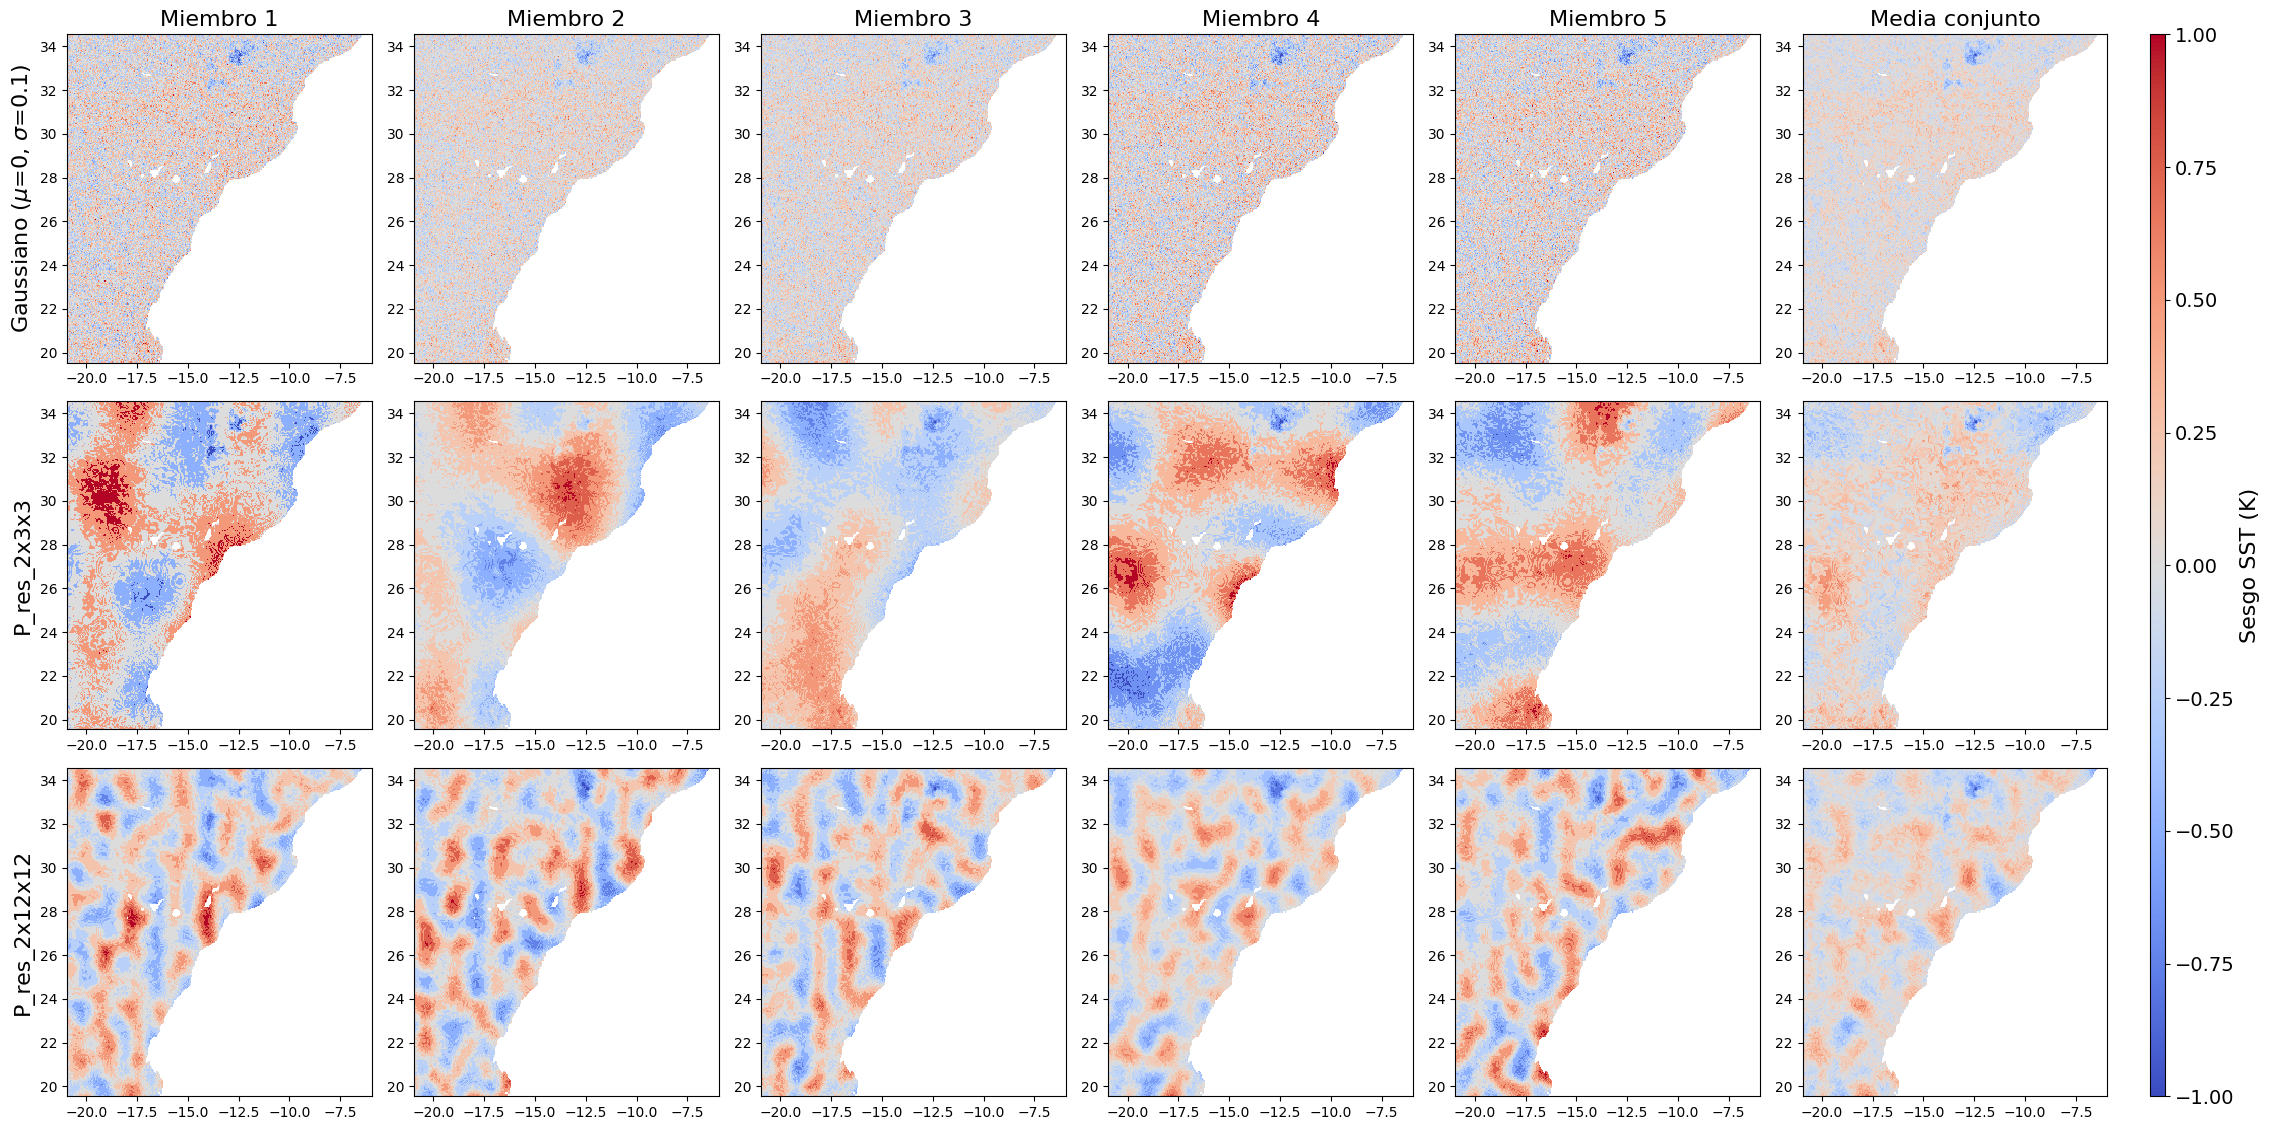

In [2]:
datasets = {
    "Gaussiano ($\\mu$=0, $\\sigma$=0.1)": xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2022_data.nc"),
    "P_res_2x3x3": xr.open_dataset("data/atlantic/predictions/ensemble_perlin_3_3_2022_data.nc"),
    "P_res_2x12x12": xr.open_dataset("data/atlantic/predictions/ensemble_perlin_12_12_2022_data.nc"),
}

target = xr.open_dataset("data/atlantic/predictions/targets_dataset.nc")
target_sst = target["sst_temperature"].sel(lead_time="1 days")

n_ensembles = len(datasets)
n_members = 5

fig = plt.figure(figsize=(4 * n_members + 4, 4 * n_ensembles))
gs = gridspec.GridSpec(nrows=n_ensembles, ncols=n_members + 2, 
                       width_ratios=[1]*n_members + [1] + [0.05], figure=fig)

axes = []
for i in range(n_ensembles):
    row_axes = []
    for j in range(n_members + 1):
        ax = fig.add_subplot(gs[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

for row_idx, (label, ds) in enumerate(datasets.items()):
    sst = ds["sst_temperature"].sel(lead_time="1 days")
    is_ensemble = "number" in sst.dims
    
    for col_idx in range(n_members):
        ax = axes[row_idx][col_idx]
        
        if is_ensemble:
            member_data = sst.sel(number=col_idx)
            diff = member_data - target_sst
        
        diff_mean_member = diff.sel(init_time="2022-01-03")
        
        im = diff_mean_member.plot(
            ax=ax,
            cmap="coolwarm",
            add_colorbar=False,
            add_labels=False,
        )
        
        ax.set_xlabel("")
        ax.set_ylabel("")
        
        if row_idx == 0:
            ax.set_title(f"Miembro {col_idx+1}", fontsize=16)
        if col_idx == 0:
            ax.set_ylabel(label, fontsize=16)

    ax_mean = axes[row_idx][-1]
    mean_data = sst.mean(dim="number")
    diff_mean_unified = mean_data - target_sst
    diff_mean = diff_mean_unified.sel(init_time="2022-01-03")

    im_mean = diff_mean.plot(
        ax=ax_mean,
        cmap="coolwarm",
        add_colorbar=False,
        add_labels=False,
    )
    if row_idx == 0:
        ax_mean.set_title("Media conjunto", fontsize=16)

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', label="Sesgo SST (K)")
cbar.set_label("Sesgo SST (K)", fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()

In [ ]:
det_ds = xr.open_dataset(r"data/atlantic/predictions/predictions_dataset_without_noise_mean.nc")
det_sst = det_ds["sst_temperature"].sel(lead_time="1 days")
diff_det = det_sst.sel(init_time="2022-01-03") - target_sst.sel(init_time="2022-01-03")

ax_det = fig.add_subplot(gs[-1, 2:4])
im_det = diff_det.plot(ax=ax_det, cmap="coolwarm", add_colorbar=False)
ax_det.set_title("Predicción Determinista", fontsize=14)
ax_det.set_xlabel("")
ax_det.set_ylabel("")

cbar_ax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label="Diferencia SST (K)").ax.tick_params(labelsize=12)


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_11056\3332186807.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  "Gaussiano ($\\mu$=0, $\\sigma^2$=0.1)": xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2022_data.nc"),
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_11056\3332186807.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  "P_res_2x3x3": xr.open_dataset("data/atlantic/predictions/ensemble_perlin_3_3_2022_data.nc"),
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_11056\3332186807.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTim

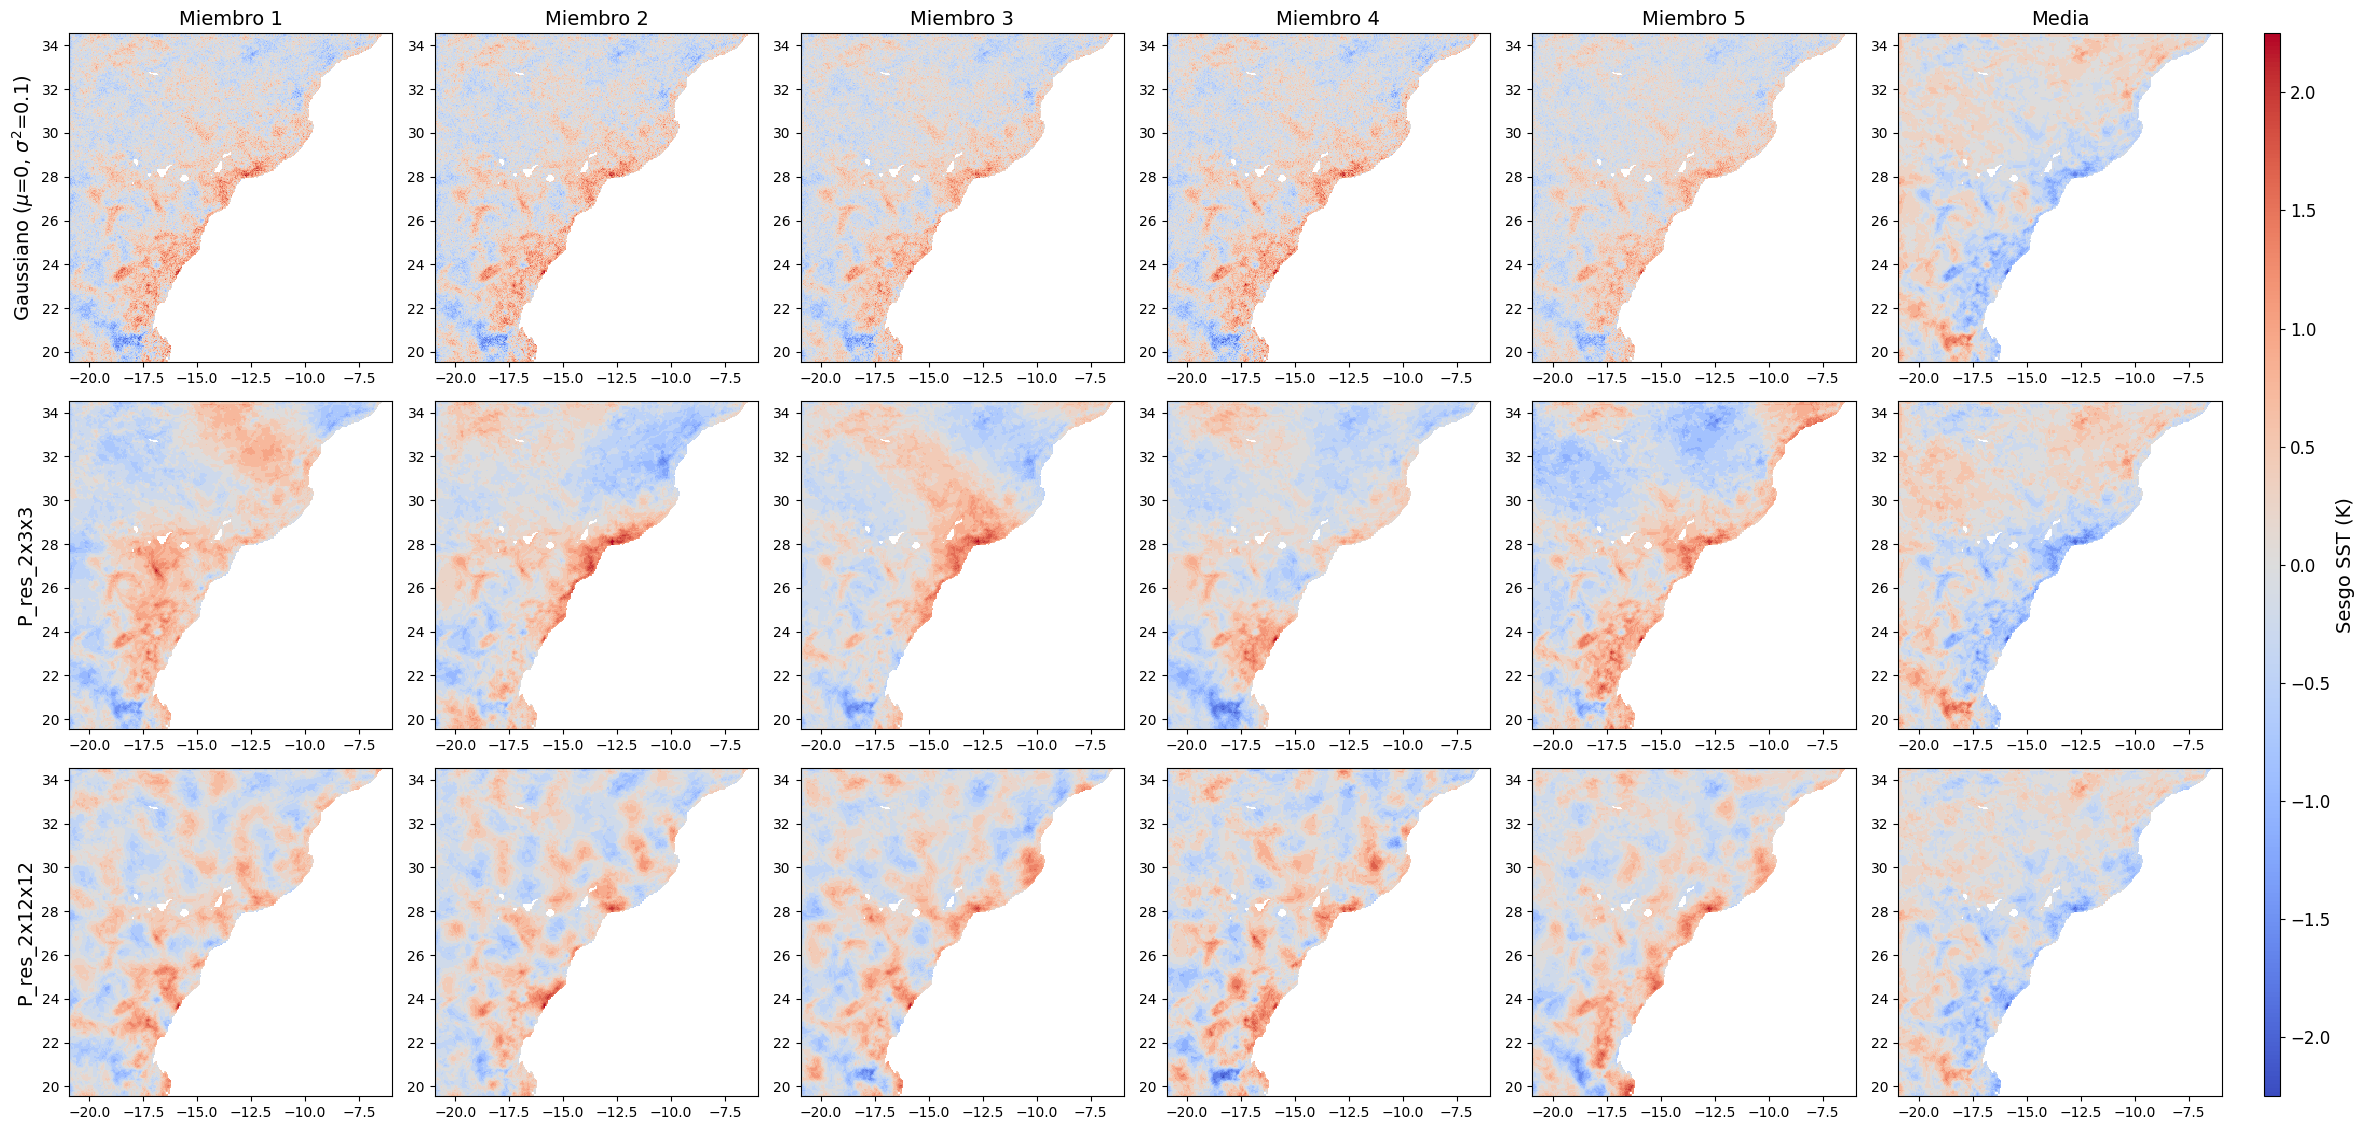

In [3]:
datasets = {
    "Gaussiano ($\\mu$=0, $\\sigma^2$=0.1)": xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2022_data.nc"),
    "P_res_2x3x3": xr.open_dataset("data/atlantic/predictions/ensemble_perlin_3_3_2022_data.nc"),
    "P_res_2x12x12": xr.open_dataset("data/atlantic/predictions/ensemble_perlin_12_12_2022_data.nc"),
}

dataset_mean = {
    "Gaussiano ($\\mu$=0, $\\sigma^2$=0.1)": xr.open_dataset("data/atlantic/predictions/predictions_dataset_gaussian_01_mean.nc"),
    "P_res_2x3x3": xr.open_dataset("data/atlantic/predictions/predictions_dataset_perlin_3d_3_3_mean.nc"),
    "P_res_2x12x12": xr.open_dataset("data/atlantic/predictions/predictions_dataset_perlin_3d_12_12_mean.nc"),
}

target = xr.open_dataset("data/atlantic/predictions/targets_dataset.nc")
target_sst = target["sst_temperature"].sel(lead_time="15 days")

n_ensembles = len(datasets)
n_members = 5

fig = plt.figure(figsize=(4 * (n_members + 1) + 1, 4 * n_ensembles))
gs = gridspec.GridSpec(
    nrows=n_ensembles,
    ncols=n_members + 2,
    width_ratios=[1] * (n_members + 1) + [0.05],
    figure=fig
)

axes = []
for i in range(n_ensembles):
    row_axes = []
    for j in range(n_members + 1):
        ax = fig.add_subplot(gs[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

for row_idx, (label, ds) in enumerate(datasets.items()):
    sst = ds["sst_temperature"].sel(lead_time="15 days")
    is_ensemble = "number" in sst.dims

    for col_idx in range(n_members):
        ax = axes[row_idx][col_idx]
        if is_ensemble:
            member_data = sst.sel(number=col_idx)
            diff = member_data - target_sst
        diff_first = diff.sel(init_time=diff.init_time[0])

        im = diff_first.plot(
            ax=ax,
            cmap="coolwarm",
            add_colorbar=False,
            add_labels=False,
        )

        ax.set_xlabel("")
        ax.set_ylabel("")

        if row_idx == 0:
            ax.set_title(f"Miembro {col_idx+1}", fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(label, fontsize=14)

    ax = axes[row_idx][n_members]
    mean_ds = dataset_mean[label]
    mean_sst = mean_ds["sst_temperature"].sel(lead_time="15 days")
    diff_mean = target_sst - mean_sst
    diff_first_mean = diff_mean.sel(init_time=diff_mean.init_time[0])

    im = diff_first_mean.plot(
        ax=ax,
        cmap="coolwarm",
        add_colorbar=False,
        add_labels=False,
    )

    ax.set_xlabel("")
    ax.set_ylabel("")
    if row_idx == 0:
        ax.set_title("Media", fontsize=14)

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', label="Sesgo SST (K)")
cbar.ax.yaxis.label.set_size(14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18480\391911621.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  "Gaussiano ($\\mu$=0, $\\sigma$=0.1)": xr.open_dataset("data/atlantic/predictions/predictions_dataset_gaussian_01_mean.nc"),
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18480\391911621.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  "P_res_2x3x3": xr.open_dataset("data/atlantic/predictions/predictions_dataset_perlin_3d_3_3_mean.nc"),
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18480\391911621.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False

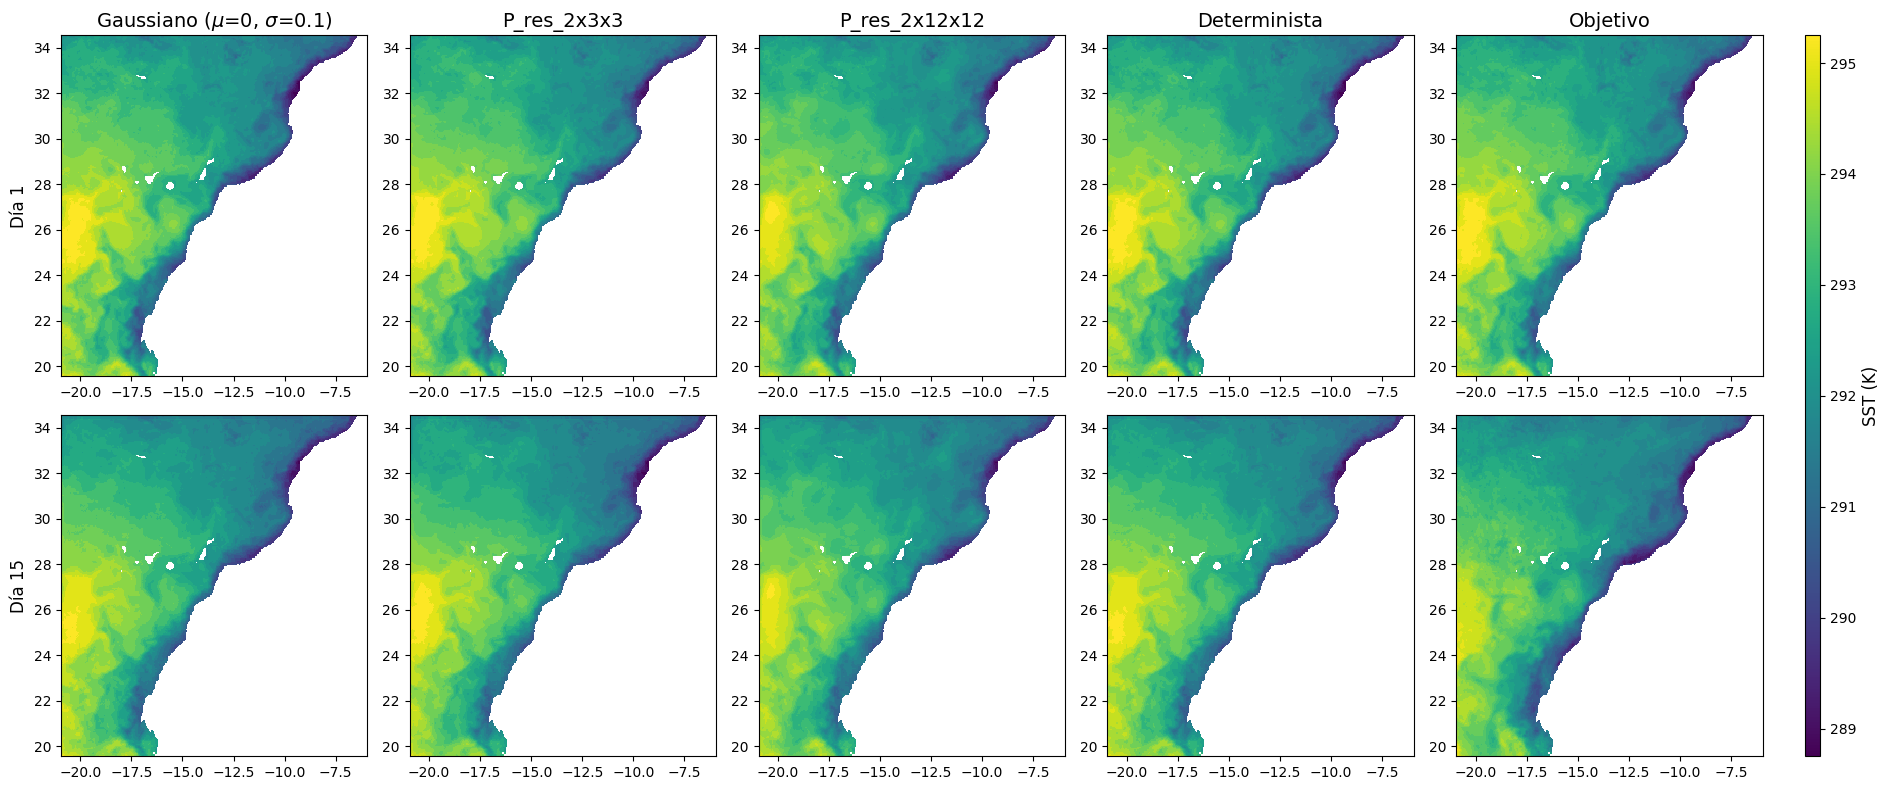

In [5]:
dataset_mean = {
    "Gaussiano ($\\mu$=0, $\\sigma$=0.1)": xr.open_dataset("data/atlantic/predictions/predictions_dataset_gaussian_01_mean.nc"),
    "P_res_2x3x3": xr.open_dataset("data/atlantic/predictions/predictions_dataset_perlin_3d_3_3_mean.nc"),
    "P_res_2x12x12": xr.open_dataset("data/atlantic/predictions/predictions_dataset_perlin_3d_12_12_mean.nc"),
}

deterministic = xr.open_dataset(r"data\atlantic\predictions\predictions_dataset_without_noise_mean.nc")
target = xr.open_dataset("data/atlantic/predictions/targets_dataset.nc")

dias = ["1 days", "15 days"]
configs = list(dataset_mean.keys()) + ["Determinista", "Objetivo"]

n_rows = len(dias)
n_cols = len(configs)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))
gs = gridspec.GridSpec(nrows=n_rows, ncols=n_cols + 1, figure=fig, width_ratios=[1]*n_cols + [0.05])

def plot_sst(ax, sst, cmap="viridis"):
    im = sst.plot(ax=ax, cmap=cmap, add_colorbar=False, add_labels=False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    return im


for row_idx, dia in enumerate(dias):
    for col_idx, config in enumerate(configs):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        if config in dataset_mean:
            ds = dataset_mean[config]
            sst = ds["sst_temperature"].sel(lead_time=dia).sel(init_time=ds.init_time[0])
        elif config == "Determinista":
            sst = deterministic["sst_temperature"].sel(lead_time=dia).sel(init_time=deterministic.init_time[0])
        else:
            sst = target["sst_temperature"].sel(lead_time=dia).sel(init_time=target.init_time[0])
        
        im = plot_sst(ax, sst)
        
        if row_idx == 0:
            ax.set_title(config, fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(f"Día {row_idx*14 + 1}", fontsize=12)

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar.set_label("SST (K)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


### Cálculo de métricas

#### Pruebas Gaussian (0.1)

In [ ]:
directories_gaussian = [r"data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions", r"data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions", r"data\atlantic\predictions\gaussian\run-20250525_202636-9ucmeenc\files\predictions", r"data\atlantic\predictions\gaussian\run-20250526_001455-nfmwznoc\files\predictions",
r"data\atlantic\predictions\gaussian\run-20250527_190605-gh4g5mks\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [ ]:
process_and_save_metrics(date_ranges_2022, "2022", "gaussian", directories_gaussian)

In [ ]:
process_and_save_metrics(date_ranges_2023, "2023", "gaussian", directories_gaussian)

In [ ]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2022.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2023.nc")

In [ ]:
combined_metrics_gaussian = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_gaussian.to_netcdf("data/atlantic/predictions/metrics_combined_gaussian.nc")

#### Pruebas Gaussian (0.01)

In [4]:
directories_gaussian = [r"data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions", r"data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions", r"data\atlantic\predictions\gaussian_01\run-20250622_151113-ye4zg4wy\files\predictions", r"data\atlantic\predictions\gaussian_01\run-20250622_174610-d8lg34hb\files\predictions",
r"data\atlantic\predictions\gaussian_01\run-20250622_201726-dfy7vvwy\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [5]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [6]:
metrics = {
    "crps" : probabilistic.CRPSEnsemble(),
    "rmse_unb": probabilistic.UnbiasedEnsembleMeanRMSE(skipna_ensemble=True),
    "spread_skill_ratio": probabilistic.SpreadSkillRatio(skipna_ensemble=True),
    "spread_skill_ratio_unb": probabilistic.UnbiasedSpreadSkillRatio(skipna_ensemble=True),
}

aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude'], skipna=True
)

In [8]:
process_and_save_metrics(date_ranges_2022, "2022", "gaussian_01", directories_gaussian)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_151113-ye4zg4wy\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_174610-d8lg34hb\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_201726-dfy7vvwy\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions
Loaded 89 data

In [7]:
process_and_save_metrics(date_ranges_2023, "2023", "gaussian_01", directories_gaussian)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_151113-ye4zg4wy\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_174610-d8lg34hb\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_201726-dfy7vvwy\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions
Loaded 89 data

In [8]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_01_2022.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_01_2023.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15160\140150390.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_01_2022.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15160\140150390.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_01_2023.nc")


In [9]:
combined_metrics_gaussian = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_gaussian.to_netcdf("data/atlantic/predictions/metrics_combined_gaussian_01.nc")

#### Pruebas Perlin Fractal 3d 1x3x3

In [4]:
directories_perlin_fractal = [r"data\atlantic\predictions\perlin_fractal\run-20250529_123504-gsn31pxv\files\predictions", r"data\atlantic\predictions\perlin_fractal\run-20250530_124508-jf420kyt\files\predictions", r"data\atlantic\predictions\perlin_fractal\run-20250531_172801-ye9kajqq\files\predictions", r"data\atlantic\predictions\perlin_fractal\run-20250601_140952-l2uuvw2x\files\predictions",
r"data\atlantic\predictions\perlin_fractal\run-20250601_162733-yi5t7ib3\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [5]:
metrics = {
    "crps" : probabilistic.CRPSEnsemble(),
    "rmse_unb": probabilistic.UnbiasedEnsembleMeanRMSE(skipna_ensemble=True),
    "spread_skill_ratio": probabilistic.SpreadSkillRatio(skipna_ensemble=True),
    "spread_skill_ratio_unb": probabilistic.UnbiasedSpreadSkillRatio(skipna_ensemble=True),
}

aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude'], skipna=True
)

In [6]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [7]:
process_and_save_metrics(date_ranges_2022, "2022", "perlin_fractal", directories_perlin_fractal)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Procesando rango de fechas: 2022-07-01 00:00:00 a 2022-09-30 00:00:00
Procesando rango de fechas: 2022-10-01 00:00:00 a 2022-12-31 00:00:00


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [8]:
process_and_save_metrics(date_ranges_2023, "2023", "perlin_fractal", directories_perlin_fractal)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Procesando rango de fechas: 2023-07-01 00:00:00 a 2023-09-08 00:00:00
Procesando rango de fechas: 2023-09-09 00:00:00 a 2023-12-17 00:00:00


In [2]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2022.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2023.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1324\4048024542.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2022.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1324\4048024542.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2023.nc")


In [10]:
combined_metrics_perlin = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_perlin.to_netcdf("data/atlantic/predictions/metrics_combined_perlin_fractal.nc")

#### Pruebas 3d 2x3x3

In [5]:
directories_perlin_3_3 = [r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions",
r"data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [6]:
metrics = {
    "crps" : probabilistic.CRPSEnsemble(),
    "rmse_unb": probabilistic.UnbiasedEnsembleMeanRMSE(skipna_ensemble=True),
    "spread_skill_ratio": probabilistic.SpreadSkillRatio(skipna_ensemble=True),
    "spread_skill_ratio_unb": probabilistic.UnbiasedSpreadSkillRatio(skipna_ensemble=True),
}

aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude'], skipna=True
)

In [7]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [8]:
process_and_save_metrics(date_ranges_2022, "2022", "perlin_fractal", directories_perlin_3_3)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 88 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 89 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2022-07-01 00:00:00 a 2022-09-30 00:00:00
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 90 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2022-10-01 00:00:00 a 2022-12-31 00:00:00
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 90 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [9]:
process_and_save_metrics(date_ranges_2023, "2023", "perlin_fractal", directories_perlin_3_3)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 88 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 89 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2023-07-01 00:00:00 a 2023-09-08 00:00:00
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 68 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2023-09-09 00:00:00 a 2023-12-17 00:00:00
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 98 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [12]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2022.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2023.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15132\4048024542.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2022.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15132\4048024542.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2023.nc")


In [13]:
combined_metrics_perlin = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_perlin.to_netcdf("data/atlantic/predictions/metrics_combined_perlin_3_3.nc")

#### Perlin 3d 3x12_12

In [4]:
directories_perlin_12_12 = [r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions",
r"data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [5]:
metrics = {
    "crps" : probabilistic.CRPSEnsemble(),
    "rmse_unb": probabilistic.UnbiasedEnsembleMeanRMSE(skipna_ensemble=True),
    "spread_skill_ratio": probabilistic.SpreadSkillRatio(skipna_ensemble=True),
    "spread_skill_ratio_unb": probabilistic.UnbiasedSpreadSkillRatio(skipna_ensemble=True),
}

aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude'], skipna=True
)

In [6]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [7]:
process_and_save_metrics(date_ranges_2022, "2022", "perlin_3d_12_12", directories_perlin_12_12)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\file

In [8]:
process_and_save_metrics(date_ranges_2023, "2023", "erlin_3d_12_12", directories_perlin_12_12)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\file

In [9]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_3d_12_12_2022.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_erlin_3d_12_12_2023.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1952\2823607401.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_3d_12_12_2022.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1952\2823607401.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_erlin_3d_12_12_2023.nc")


In [11]:
combined_metrics_perlin_12_12 = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_perlin_12_12.to_netcdf("data/atlantic/predictions/metrics_combined_perlin_12_12.nc")

#### Perlin Fractal 2d 005 esc

In [7]:
directories_perlin_fractal_2d_005 = [r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions", r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_215342-znfh11ww\files\predictions", r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_104826-tizjx546\files\predictions", r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_172314-hx6thv8d\files\predictions",
r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_220724-k1bggi8k\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [8]:
metrics = {
    "crps" : probabilistic.CRPSEnsemble(),
    "rmse_unb": probabilistic.UnbiasedEnsembleMeanRMSE(skipna_ensemble=True),
    "spread_skill_ratio": probabilistic.SpreadSkillRatio(skipna_ensemble=True),
    "spread_skill_ratio_unb": probabilistic.UnbiasedSpreadSkillRatio(skipna_ensemble=True),
}

aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude'], skipna=True
)

In [9]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [10]:
process_and_save_metrics(date_ranges_2022, "2022", "perlin_fractal_2d_005", directories_perlin_fractal_2d_005)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00


Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_215342-znfh11ww\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_104826-tizjx546\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_172314-hx6thv8d\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_220724-k1bggi8k\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_215342-znfh11ww\files\predictions
Loaded 89 data

In [11]:
process_and_save_metrics(date_ranges_2023, "2023", "perlin_fractal_2d_005", directories_perlin_fractal_2d_005)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_215342-znfh11ww\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_104826-tizjx546\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_172314-hx6thv8d\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_220724-k1bggi8k\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin_fracta

In [12]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2d_005_2022.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2d_005_2023.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_14652\292214918.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2d_005_2022.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_14652\292214918.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2d_005_2023.nc")


In [14]:
combined_metrics_perlin_fractal_2d_005  = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_perlin_fractal_2d_005.to_netcdf("data/atlantic/predictions/metrics_combined_perlin_fractal_2d_005.nc")

### Comparación de resultados

In [4]:
combined_metrics_gaussian = xr.open_dataset(r"data\atlantic\predictions\metrics_combined_gaussian.nc")
combined_metrics_perlin = xr.open_dataset(r"data\atlantic\predictions\metrics_combined_perlin_fractal.nc")
combined_metrics_gaussian_01 = xr.open_dataset(r"data\atlantic\predictions\metrics_combined_gaussian_01.nc")
combined_metrics_perlin_3_3 = xr.open_dataset(r"data\atlantic\predictions\metrics_combined_perlin_3_3.nc")
combined_metrics_perlin_3d_12_12 = xr.open_dataset(r"data\atlantic\predictions\metrics_combined_perlin_12_12.nc")
combined_metrics_perlin_fractal_2d_005 = xr.open_dataset(r"data\atlantic\predictions\metrics_combined_perlin_fractal_2d_005.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_4644\2368959863.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  combined_metrics_gaussian = xr.open_dataset(r"data\atlantic\predictions\metrics_combined_gaussian.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_4644\2368959863.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  combined_metrics_perlin = xr.open_dataset(r"data\atlantic\predictions\metrics_combined_perlin_fractal.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_4644\2368959863.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedelt

In [6]:
lead_days = (combined_metrics_perlin["lead_time"] / np.timedelta64(1, "D")).values

#### Viendo evolución gráfia de métricas

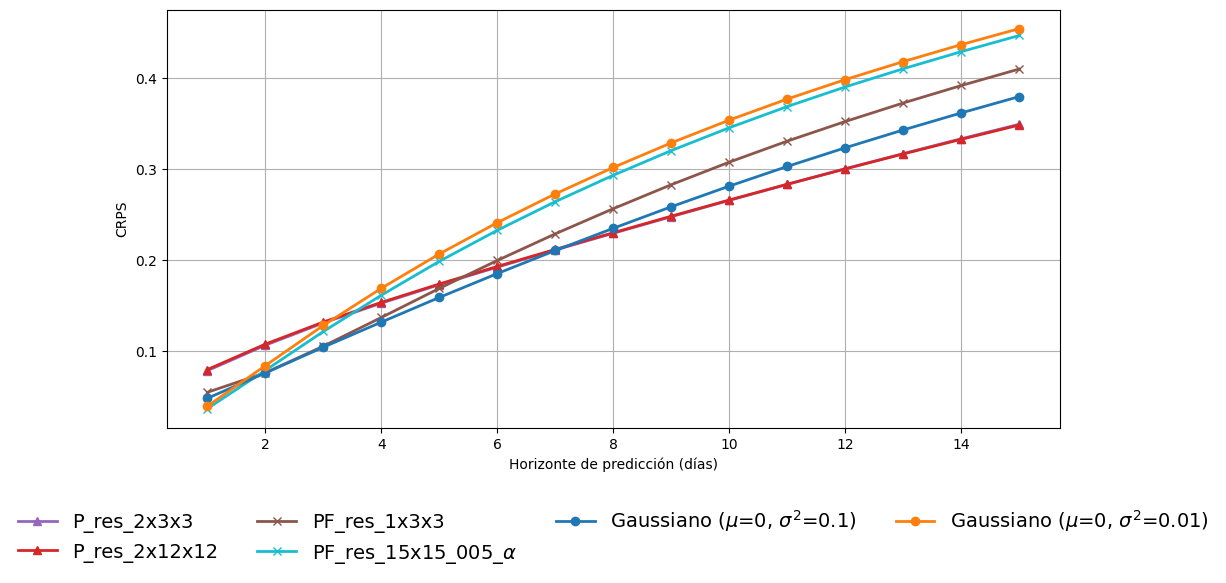

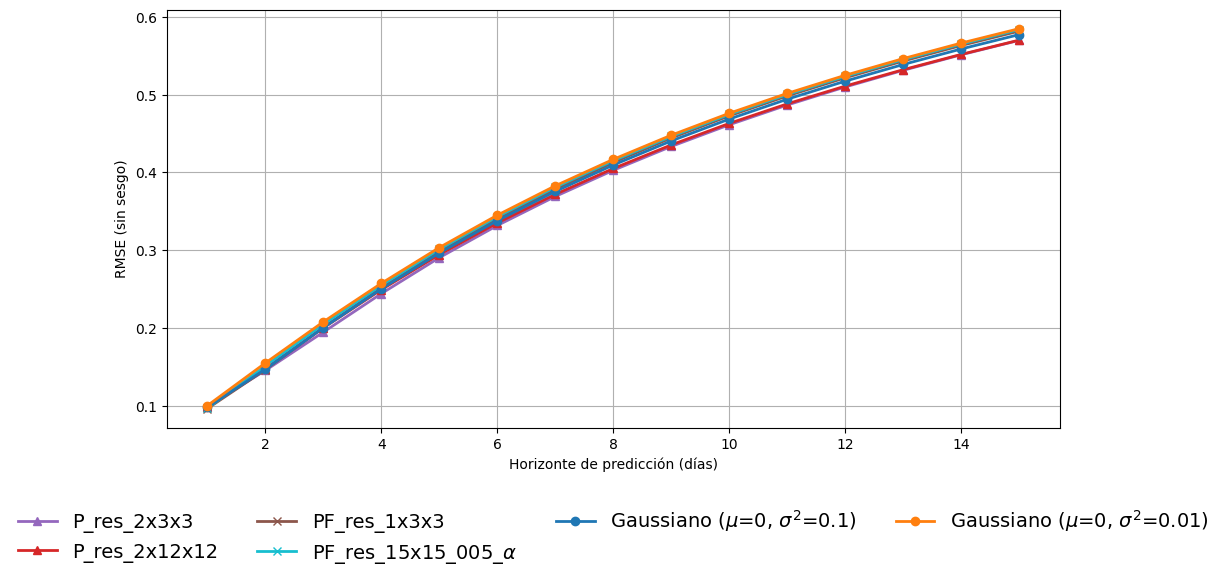

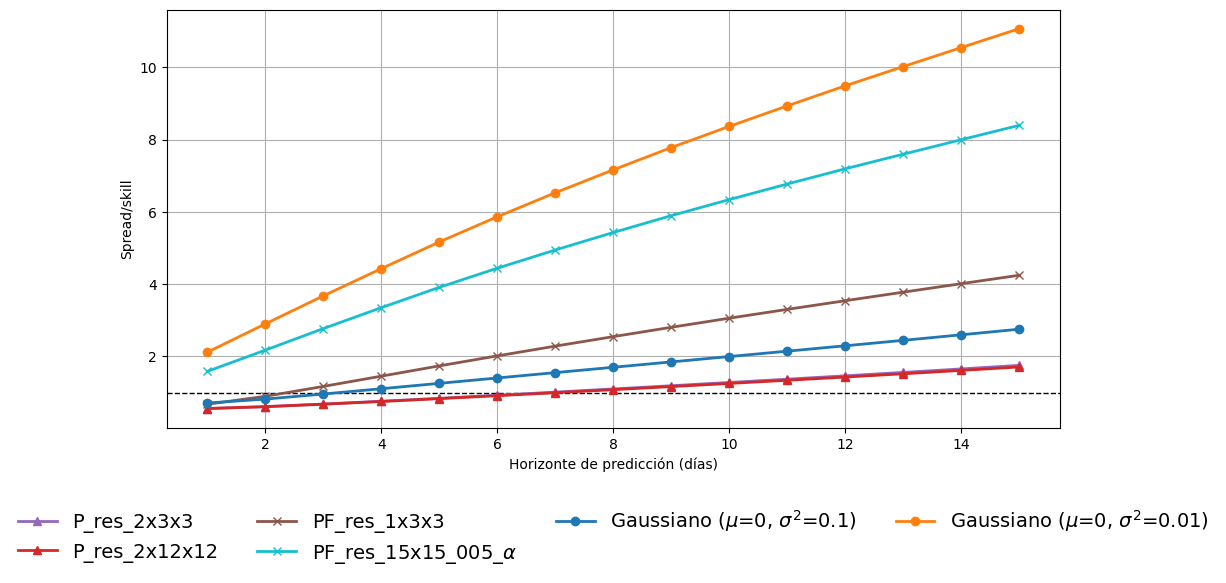

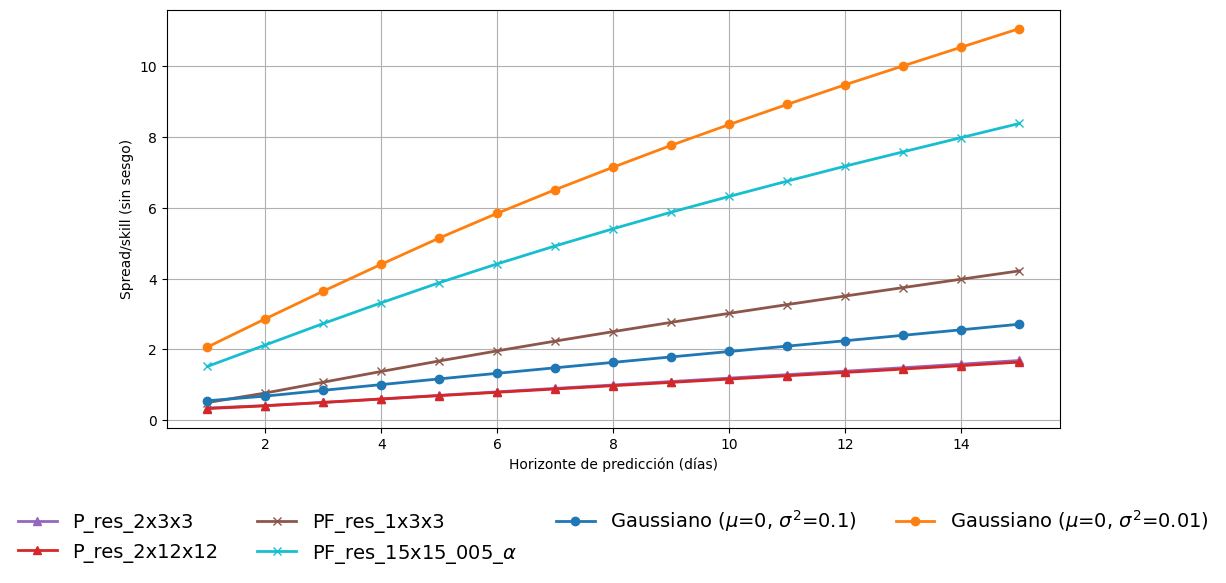

In [7]:
for metric in ["crps.sst_temperature", "rmse_unb.sst_temperature",
               "spread_skill_ratio.sst_temperature", "spread_skill_ratio_unb.sst_temperature"]:

    plt.figure(figsize=(12, 6))

    if metric == "spread_skill_ratio.sst_temperature" or "spread_skill_ratio_unb.sst_temperature":
        plt.axhline(
            y=1,
            color="black",
            linestyle="--",
            linewidth=1,
        )
        
    plt.plot(
        lead_days,
        combined_metrics_perlin_3_3[metric].mean(dim="init_time"),
        label="P_res_2x3x3",
        marker='^',
        color="#9467bd",
        linewidth=2
    )
    plt.plot(
        lead_days,
        combined_metrics_perlin_3d_12_12[metric].mean(dim="init_time"),
        label="P_res_2x12x12",
        marker='^',
        color="#d62728",
        linewidth=2
    )
    plt.plot(
        lead_days,
        combined_metrics_perlin_fractal_2d_005[metric].mean(dim="init_time"),
        label=r"PF_res_15x15_005_$\alpha$",
        marker='x',
        color="#17becf",
        linewidth=2
    )
    plt.plot(
        lead_days,
        combined_metrics_gaussian[metric].mean(dim="init_time"),
        label="Gaussiano ($\mu$=0, $\sigma^2$=0.1)",
        marker='o',
        color="#1f77b4",
        linewidth=2
    )
    plt.plot(
        lead_days,
        combined_metrics_gaussian_01[metric].mean(dim="init_time"),
        label="Gaussiano ($\mu$=0, $\sigma^2$=0.01)",
        marker='o',
        color="#ff7f0e",
        linewidth=2
    )

    plt.xlabel("Horizonte de predicción (días)")
    plt.ylabel(dict_metric_names[metric])
    plt.grid()
    plt.legend(
        fontsize=14,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=4,
        frameon=False
    )
    plt.tight_layout()
    plt.savefig(f"metrics/real_test/5_ens_prob_{metric.replace('.', '_')}.png", dpi=300)
    plt.show()


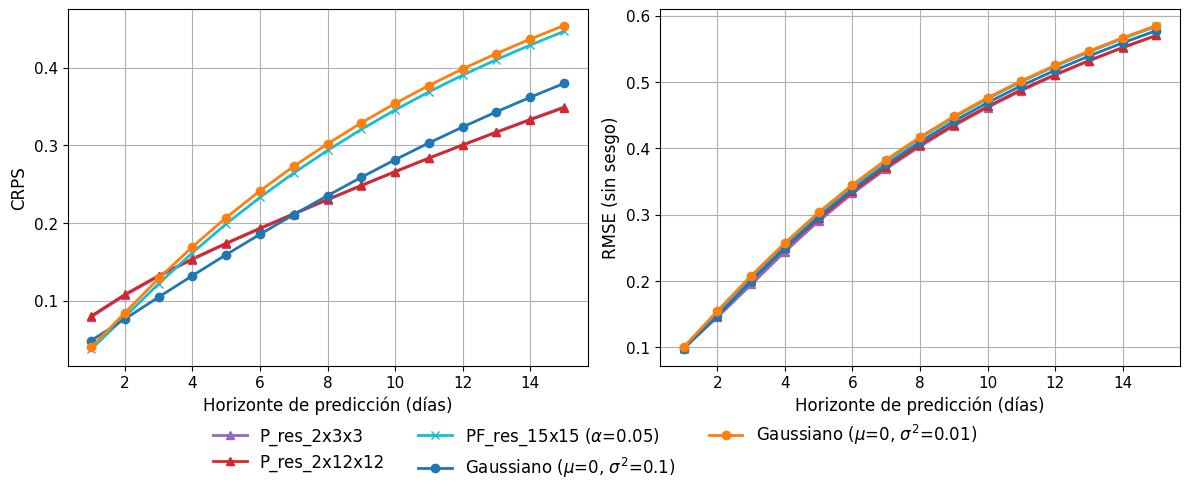

In [7]:
metrics = [
    ("crps.sst_temperature", "CRPS"),
    ("rmse_unb.sst_temperature", "RMSE (sin sesgo)"),
]

colors = {
    "P_res_2x3x3": "#9467bd",
    "P_res_2x12x12": "#d62728",
    "PF_res_15x15 ($\\alpha$=0.05)": "#17becf",
    "Gaussiano ($\\mu$=0, $\\sigma^2$=0.1)": "#1f77b4",
    "Gaussiano ($\\mu$=0, $\\sigma^2$=0.01)": "#ff7f0e",
}

markers = {
    "P_res_2x3x3": '^',
    "P_res_2x12x12": '^',
    "PF_res_15x15 ($\\alpha$=0.05)": 'x',
    "Gaussiano ($\\mu$=0, $\\sigma^2$=0.1)": 'o',
    "Gaussiano ($\\mu$=0, $\\sigma^2$=0.01)": 'o',
}

datasets = {
    "P_res_2x3x3": combined_metrics_perlin_3_3,
    "P_res_2x12x12": combined_metrics_perlin_3d_12_12,
    "PF_res_15x15 ($\\alpha$=0.05)": combined_metrics_perlin_fractal_2d_005,
    "Gaussiano ($\\mu$=0, $\\sigma^2$=0.1)": combined_metrics_gaussian,
    "Gaussiano ($\\mu$=0, $\\sigma^2$=0.01)": combined_metrics_gaussian_01,
}

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)

for idx, (metric, title) in enumerate(metrics):
    ax = fig.add_subplot(gs[0, idx])

    for label in datasets.keys():
        data = datasets[label][metric].mean(dim="init_time")
        ax.plot(
            lead_days,
            data,
            label=label,
            marker=markers[label],
            linewidth=2,
            color=colors[label]
        )

    ax.set_xlabel("Horizonte de predicción (días)", fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=11)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    fontsize=12,
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig("metrics/real_test/comparacion_CRPS_RMSE_prob.svg", format='svg', bbox_inches='tight')
plt.show()